# Fast Axiomatic Attribution for Neural Networks

The Fast Axiomatic Attribution paper introduced a new term for neural networks called X-DNN (Bias-Free Deep Neural Networks), where the bias terms are removed from all layers to improve attribution quality and interpretability while maintaining similar performance to standard deep networks.X-DNN removes all bias terms from convolutional and fully connected layers to enforce homogeneity, ensuring more faithful attributions while maintaining comparable accuracy through Batch Normalization.
It also intoduces X-Gradient (X-Grad) which is an efficient gradient-based attribution method that leverages X-DNN to highlight input features that contribute most to the model’s prediction, offering a computationally efficient alternative to Integrated Gradients.

## Problems with Older methods like IG and Smooth Grad :
- It is compuatationally expensive as IG has to loop over many interpolated images while smooth Grad has to compute for every noise added pictures and then compute average of it , but X grad is done with one forward an backward loop which can be used in realtime applications.
- Both IG and smooth struggle with bias terms they may assign importance to unimportant regions due to model biases but X grad only focuses on important regions of the object which is thus useful for many precision use cases.

### **Homogeneity in X-DNN**  

X-DNN follows the **non-negative homogeneity rule**, which states:  

$$
F(\alpha x) = \alpha F(x), \quad \text{for any } \alpha > 0
$$

This means that **if the input is scaled, the attribution scales proportionally**, ensuring consistent and interpretable feature importance. By **removing bias terms**, X-DNN preserves this property, preventing attributions from being influenced by constant shifts and making **X-Gradient more reliable** for explaining model decisions. 

## **Algorithm Steps for computing X-Grad :**  

### **1. Define X-DNN Model:**  
- Ensure **bias removal** from all layers.  
- Use **ReLU activations** to maintain nonnegative homogeneity.  

### **2. Forward Pass:**  
- Compute model output \( F(x) \) using the input \( x \).  

### **3. Backward Pass:**  
- Compute the **gradient** of the model output w.r.t. the input:  
  $$  
  \frac{\partial F(x)}{\partial x}  
  $$

### **4. Compute X-Gradient:**  
- Multiply the input \( x \) by the computed gradient:  
  $$  
  XG(x) = x \times \frac{\partial F(x)}{\partial x}  
  $$

### **5. Interpret Feature Attributions:**  
- The resulting **X-Gradient map** highlights important features.  
- Features with **higher values** contribute more to the model’s prediction.  
 
---


## Limitatons of X -Grad:

- Tanh and Sigmoid functions are not homogeneous this limits XG to networks that strictly use ReLU-based or piecewise linear activations.
- XG applies only to differentiable models.It cannot be used with decision trees, rule-based models, or non-differentiable architectures.

## Saliency with normal VGG


Processing: C:\Users\VISHNU\Downloads\africanelephant.jpg
Predicted Class (Saliency Map): 101 - tusker


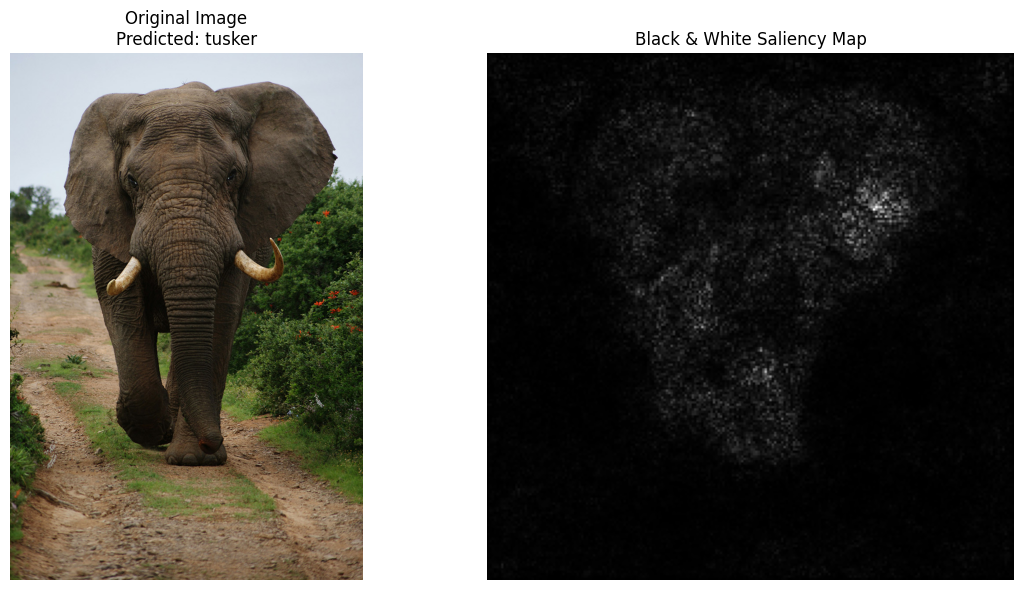


Processing: C:\Users\VISHNU\Downloads\pineapple.JPEG
Predicted Class (Saliency Map): 953 - pineapple


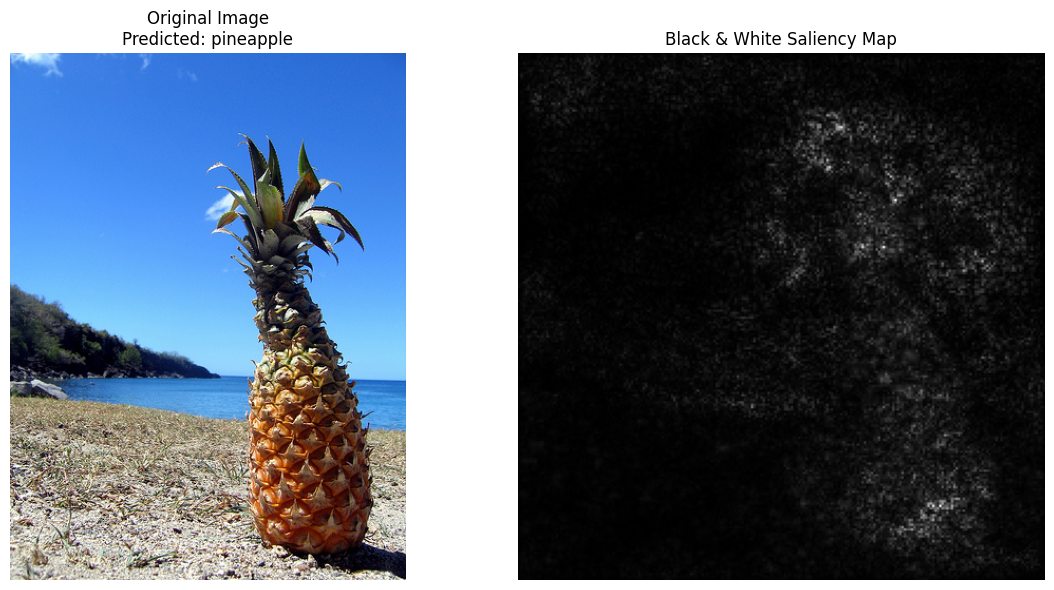


Processing: C:\Users\VISHNU\Downloads\cup.jpg
Predicted Class (Saliency Map): 504 - coffee mug


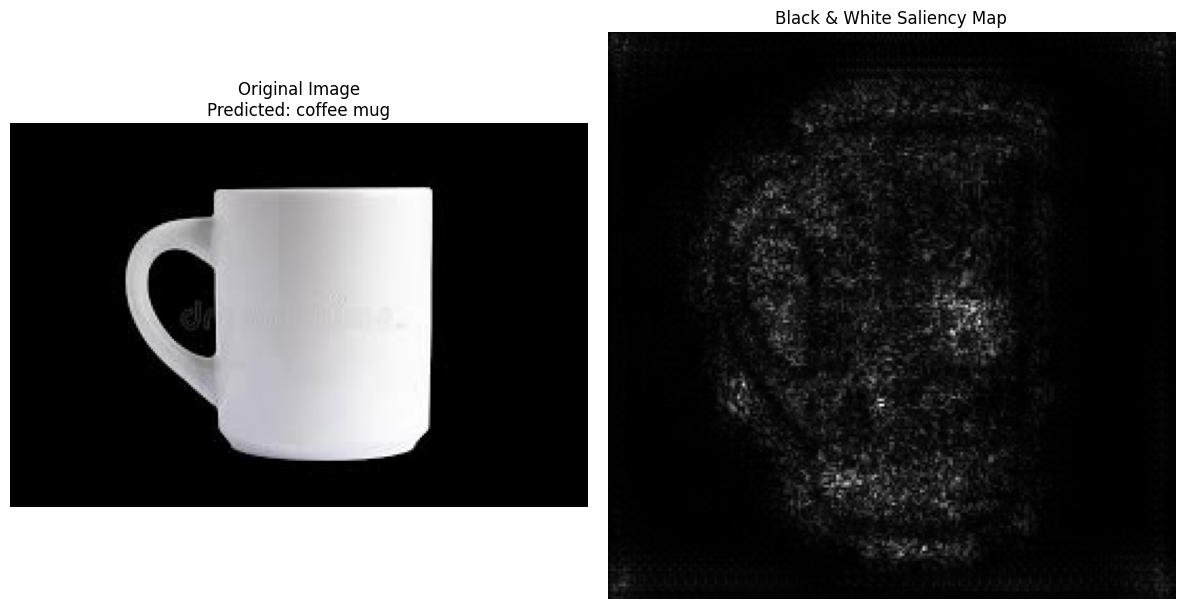


Processing: C:\Users\VISHNU\Downloads\soccer.jpg
Predicted Class (Saliency Map): 805 - soccer ball


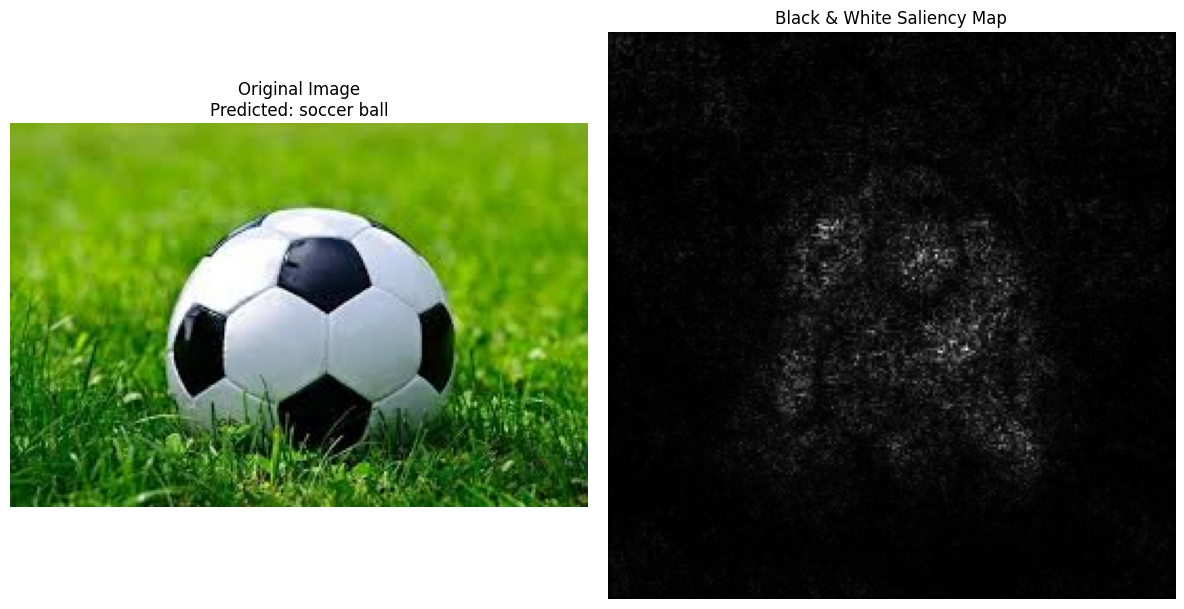

In [11]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg19(weights=models.VGG19_Weights.DEFAULT).to(device)
model.eval()  

imagenet_labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
response = requests.get(imagenet_labels_url)
imagenet_classes = response.text.splitlines()

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0) 
    return image.to(device)

def compute_saliency_map(model, x_input):
    x_input.requires_grad = True  

    output = model(x_input)
    predicted_class = torch.argmax(output, dim=1).item()
    class_name = imagenet_classes[predicted_class]
    print(f"Predicted Class (Saliency Map): {predicted_class} - {class_name}")

    target_score = output[:, predicted_class]

    
    model.zero_grad()
    target_score.backward()

    saliency = x_input.grad.abs().max(dim=1, keepdim=True)[0]

    return saliency, predicted_class, class_name

def visualize_saliency_map(saliency, original_image, class_name):
    saliency_np = saliency.squeeze().detach().cpu().numpy()
    saliency_np = (saliency_np - saliency_np.min()) / (saliency_np.max() - saliency_np.min())  # Normalize

    # Plot original image and saliency map
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_image)
    ax[0].set_title(f'Original Image\nPredicted: {class_name}')
    ax[0].axis('off')

    ax[1].imshow(saliency_np, cmap='gray')  # Use grayscale colormap
    ax[1].set_title("Black & White Saliency Map")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

def main(image_paths):
    for image_path in image_paths:  
        print(f"\nProcessing: {image_path}")
        
        x_input = preprocess_image(image_path)

        saliency, predicted_class, class_name = compute_saliency_map(model, x_input)

        original_image = Image.open(image_path).convert('RGB')

        visualize_saliency_map(saliency, original_image, class_name)

if __name__ == "__main__":
    image_paths = [
        r"C:\Users\VISHNU\Downloads\africanelephant.jpg",
        r"C:\Users\VISHNU\Downloads\pineapple.JPEG",
        r"C:\Users\VISHNU\Downloads\cup.jpg",
        r"C:\Users\VISHNU\Downloads\soccer.jpg"
    ]
    
    main(image_paths)


## X gradient with X DNN


Processing: C:\Users\VISHNU\Downloads\africanelephant.jpg
Predicted Class (X-DNN): 834 - suit

Processing: C:\Users\VISHNU\Downloads\pineapple.JPEG
Predicted Class (X-DNN): 953 - pineapple

Processing: C:\Users\VISHNU\Downloads\cup.jpg
Predicted Class (X-DNN): 968 - cup

Processing: C:\Users\VISHNU\Downloads\soccer.jpg
Predicted Class (X-DNN): 805 - soccer ball


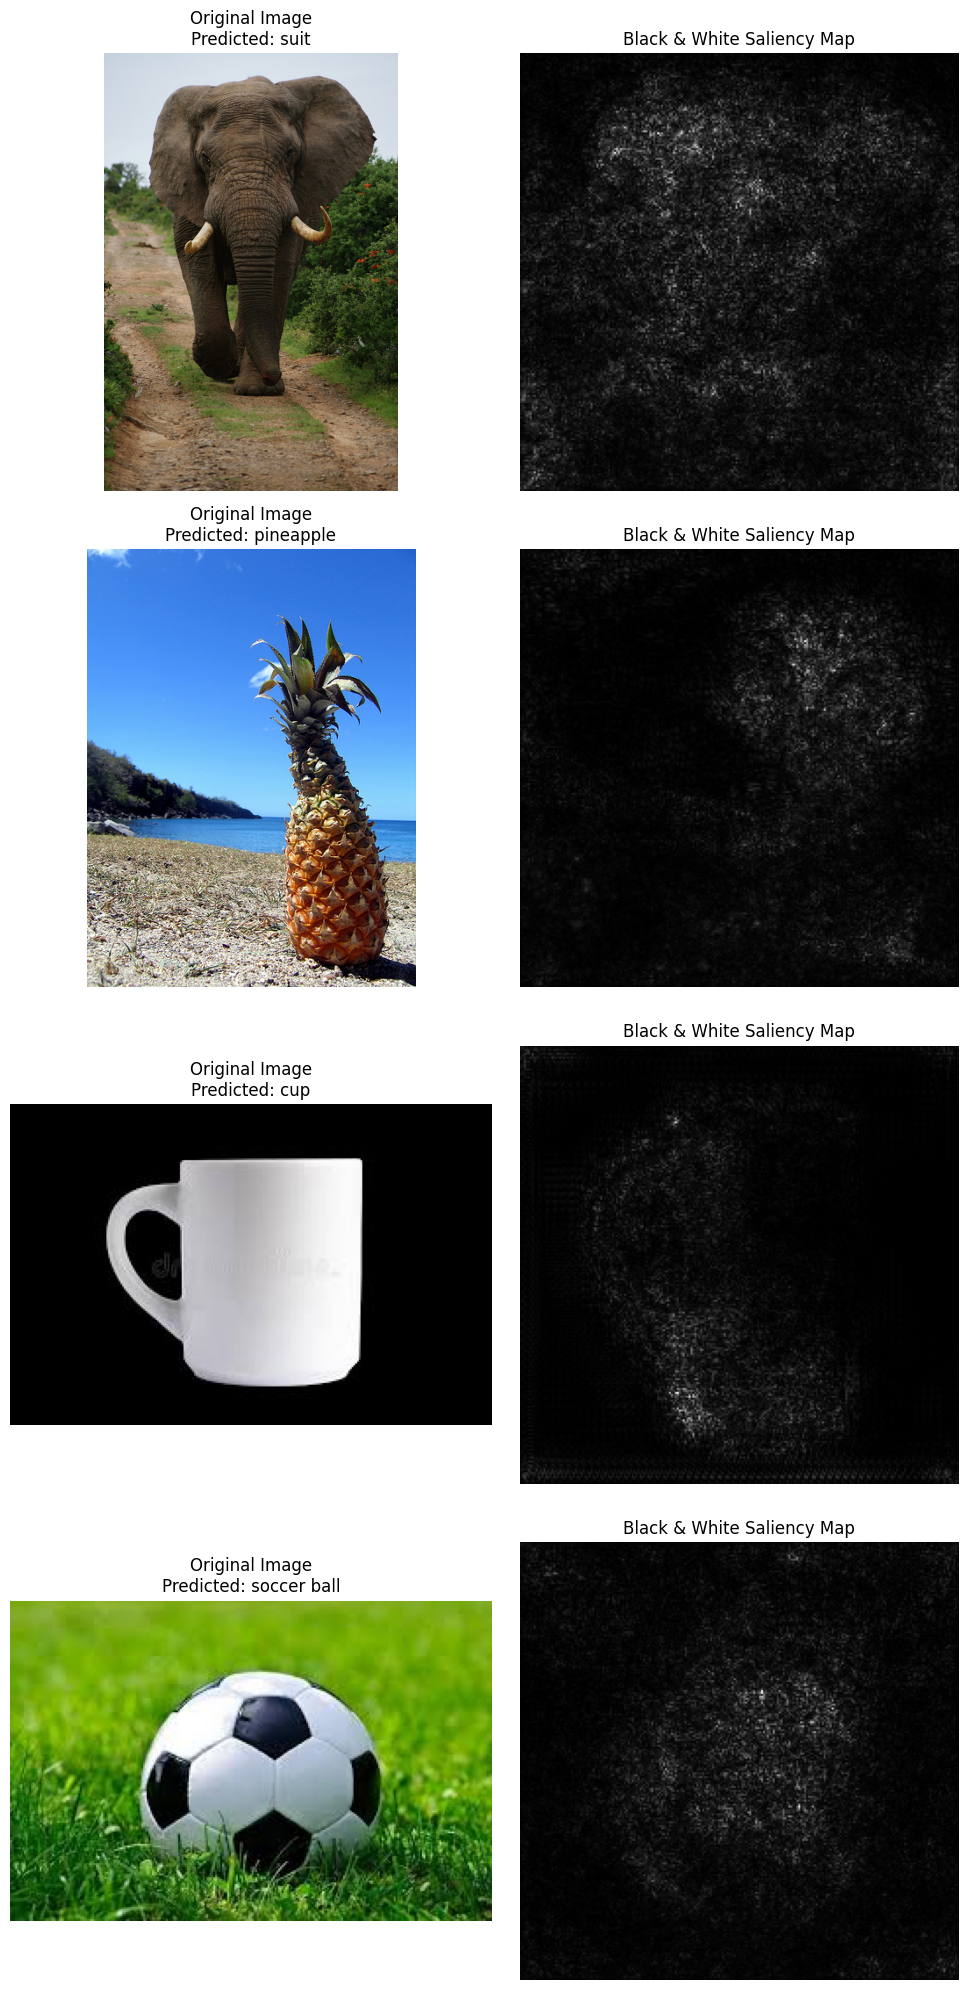

In [12]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

imagenet_labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
response = requests.get(imagenet_labels_url)
imagenet_classes = response.text.splitlines()

class X_VGG19(nn.Module):
    def __init__(self, num_classes=1000):
        super(X_VGG19, self).__init__()
        
    
        vgg19 = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
        
        for layer in vgg19.features:
            if isinstance(layer, nn.Conv2d):
                layer.bias = None  

        for layer in vgg19.classifier:
            if isinstance(layer, nn.Linear):
                layer.bias = None  

        self.features = vgg19.features
        self.avgpool = vgg19.avgpool
        self.classifier = vgg19.classifier

    def forward(self, x):
        x = self.features(x)  
        x = self.avgpool(x)   
        x = torch.flatten(x, 1)  
        x = self.classifier(x)  
        return x  # Logits output

model = X_VGG19(num_classes=1000).to(device)
model.eval()

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  
    return image.to(device)

def compute_x_gradient(model, x_input):
    x_input.requires_grad = True  
    
    output = model(x_input)
    
    predicted_class = torch.argmax(output, dim=1).item()
    class_name = imagenet_classes[predicted_class]
    print(f"Predicted Class (X-DNN): {predicted_class} - {class_name}")
    
    target_score = output[:, predicted_class]
    
    model.zero_grad()
    target_score.backward()
    
    # Compute absolute gradient (saliency map)
    x_gradient = x_input.grad.abs().max(dim=1, keepdim=True)[0]  # Max over channels to get a single-channel saliency
    return x_gradient, predicted_class, class_name

def visualize_x_gradients(images, gradients, class_names):
    num_images = len(images)
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
    
    for i in range(num_images):
        x_grad_np = gradients[i].squeeze().detach().cpu().numpy()
        x_grad_np = (x_grad_np - x_grad_np.min()) / (x_grad_np.max() - x_grad_np.min())  # Normalize
        
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title(f'Original Image\nPredicted: {class_names[i]}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(x_grad_np, cmap='gray')  # Use grayscale colormap
        axes[i, 1].set_title("Black & White Saliency Map")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()



def main(image_paths):
    images = []
    gradients = []
    class_names = []

    for image_path in image_paths:
        print(f"\nProcessing: {image_path}")
        
        x_input = preprocess_image(image_path)

        x_gradient, predicted_class, class_name = compute_x_gradient(model, x_input)

        original_image = Image.open(image_path).convert('RGB')

        images.append(original_image)
        gradients.append(x_gradient)
        class_names.append(class_name)

    # Visualize all images
    visualize_x_gradients(images, gradients, class_names)

if __name__ == "__main__":
    image_paths = [
        r"C:\Users\VISHNU\Downloads\africanelephant.jpg",
        r"C:\Users\VISHNU\Downloads\pineapple.JPEG",
        r"C:\Users\VISHNU\Downloads\cup.jpg",
        r"C:\Users\VISHNU\Downloads\soccer.jpg"
    ]
    
    main(image_paths)


## Compute X-Grad without using X -DNN


Processing: C:\Users\VISHNU\Downloads\africanelephant.jpg
Predicted Class (X-Gradient): 101 - tusker


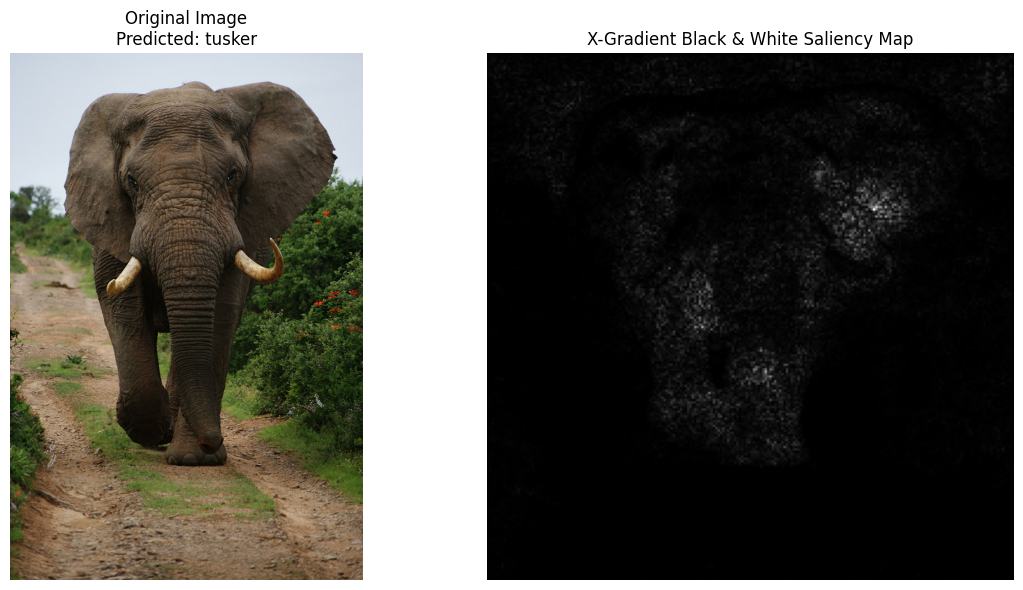


Processing: C:\Users\VISHNU\Downloads\pineapple.JPEG
Predicted Class (X-Gradient): 953 - pineapple


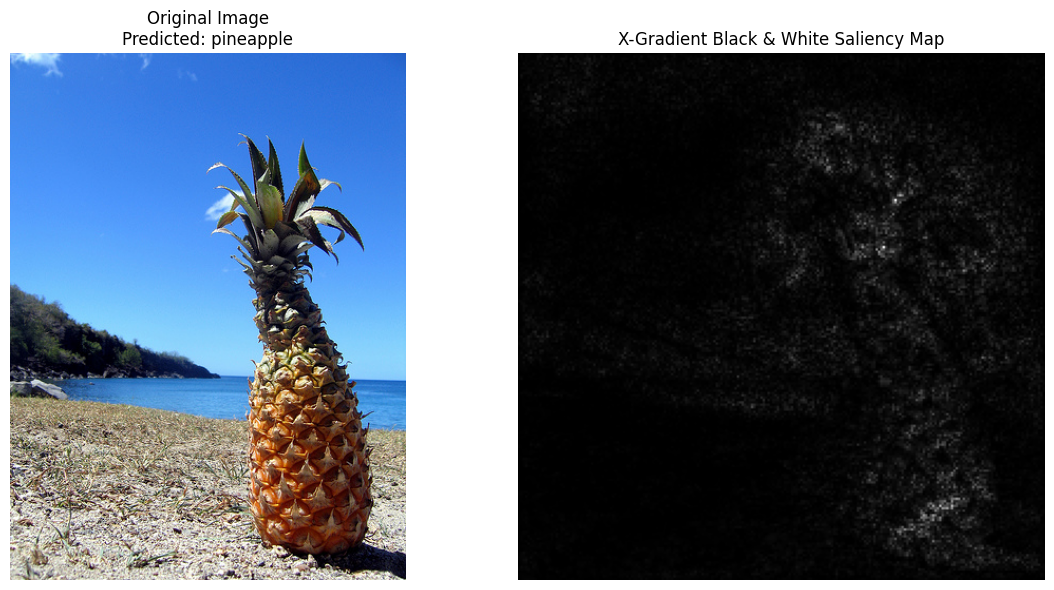


Processing: C:\Users\VISHNU\Downloads\cup.jpg
Predicted Class (X-Gradient): 504 - coffee mug


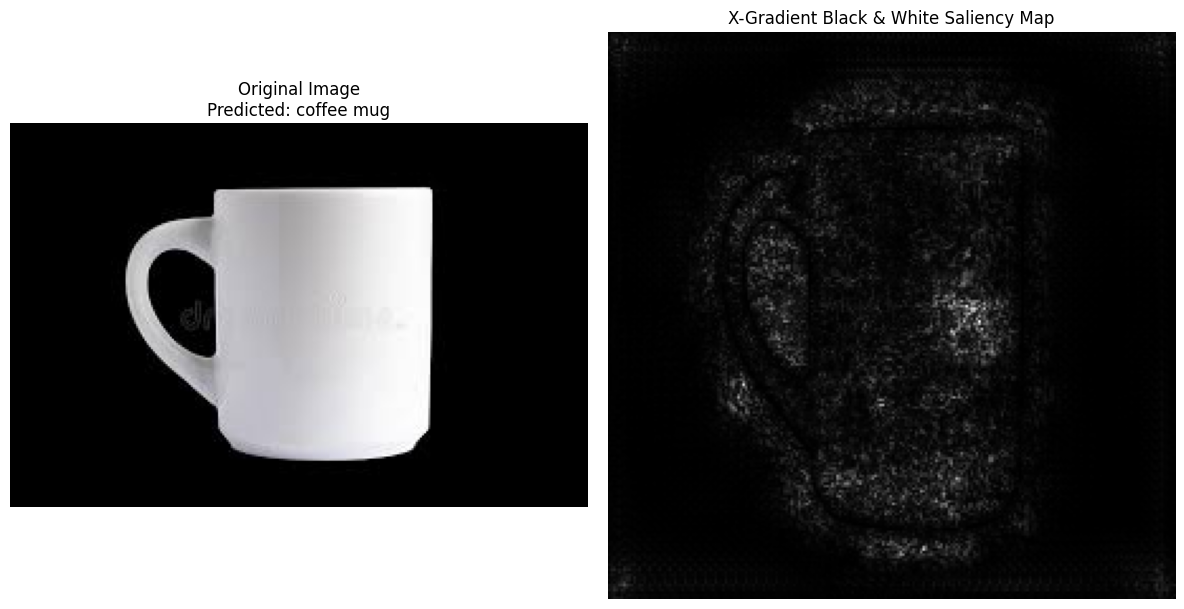


Processing: C:\Users\VISHNU\Downloads\soccer.jpg
Predicted Class (X-Gradient): 805 - soccer ball


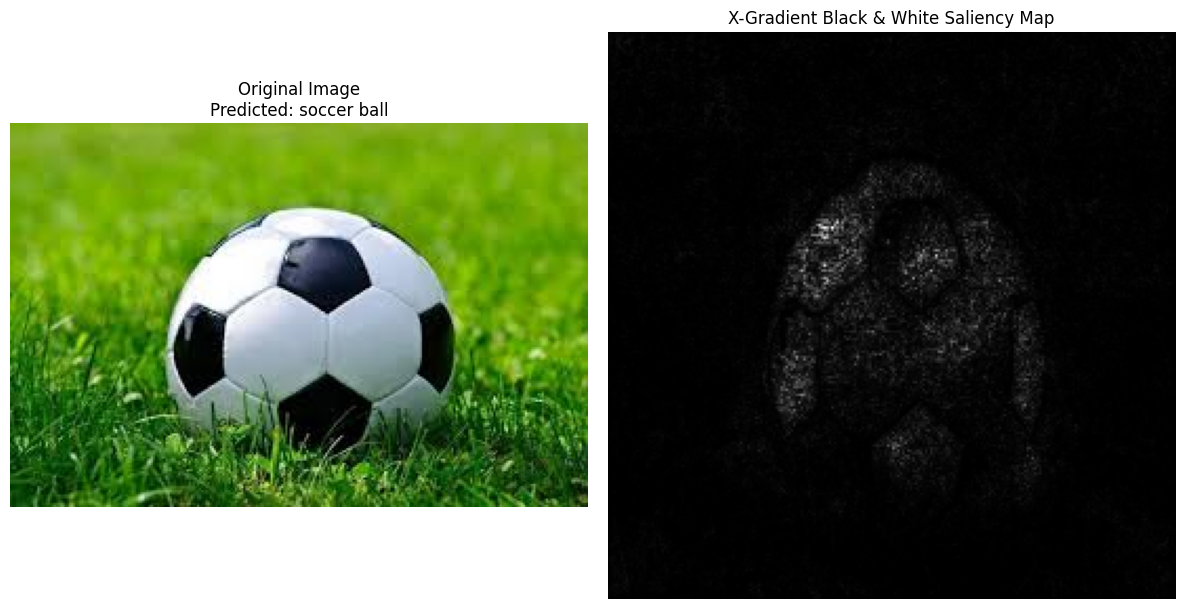

In [13]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg19(weights=models.VGG19_Weights.DEFAULT).to(device)
model.eval()  

imagenet_labels_url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
response = requests.get(imagenet_labels_url)
imagenet_classes = response.text.splitlines()

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  
    return image.to(device)

def compute_x_gradient(model, x_input):
    x_input.requires_grad = True  

    output = model(x_input)
    predicted_class = torch.argmax(output, dim=1).item()
    class_name = imagenet_classes[predicted_class]
    print(f"Predicted Class (X-Gradient): {predicted_class} - {class_name}")

    target_score = output[:, predicted_class]

    model.zero_grad()
    target_score.backward()

    x_gradient = (x_input * x_input.grad).abs().sum(dim=1)  
    return x_gradient, predicted_class, class_name

def visualize_x_gradient(saliency, original_image, class_name):
    saliency_np = saliency.squeeze().detach().cpu().numpy()
    saliency_np = (saliency_np - saliency_np.min()) / (saliency_np.max() - saliency_np.min())  

    # Plot original image and saliency map
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_image)
    ax[0].set_title(f'Original Image\nPredicted: {class_name}')
    ax[0].axis('off')

    ax[1].imshow(saliency_np, cmap='gray') 
    ax[1].set_title("X-Gradient Black & White Saliency Map")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

# Main function
def main(image_paths):
    for image_path in image_paths:  
        print(f"\nProcessing: {image_path}")
        
        x_input = preprocess_image(image_path)

        x_gradient, predicted_class, class_name = compute_x_gradient(model, x_input)

        original_image = Image.open(image_path).convert('RGB')

        visualize_x_gradient(x_gradient, original_image, class_name)

if __name__ == "__main__":
    image_paths = [
        r"C:\Users\VISHNU\Downloads\africanelephant.jpg",
        r"C:\Users\VISHNU\Downloads\pineapple.JPEG",
        r"C:\Users\VISHNU\Downloads\cup.jpg",
        r"C:\Users\VISHNU\Downloads\soccer.jpg"
    ]
    
    main(image_paths)

